# Experiment Results Analysis

This notebook loads experiment results and generates plots comparing different data loading strategies across the four classification tasks:
- Cell line classification
- Drug classification
- MOA (broad) classification
- MOA (fine) classification

In [12]:
# Imports and setup
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
notebook_dir = Path().absolute()
project_root = notebook_dir.parent.parent
sys.path.insert(0, str(project_root))

# Import analysis utilities
from training_experiments.analysis import (
    load_experiment_results,
    extract_metrics,
    create_comparison_dataframe,
    get_time_comparison,
    print_results_table,
    STRATEGY_DISPLAY_NAMES,
    TASK_DISPLAY_NAMES,
    DEFAULT_YLIM,
)
from training_experiments.analysis.plotting import (
    plot_comparison,
    plot_training_curves,
    plot_time_comparison,
)

# Set default plot style
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.dpi'] = 100

print("✓ Setup complete")

✓ Setup complete


## Configuration

Set the path to your experiment results directory:

In [13]:
# Path to experiment results
# Update this to point to your results directory
RESULTS_DIR = notebook_dir.parent / "results" / "main"

# Alternative: absolute path
# RESULTS_DIR = Path("/home/kidara/raid/volume/scDataset/training_experiments/results")

print(f"Results directory: {RESULTS_DIR}")
print(f"Exists: {RESULTS_DIR.exists()}")

if RESULTS_DIR.exists():
    print("\nContents:")
    for p in sorted(RESULTS_DIR.iterdir()):
        print(f"  {p.name}")

Results directory: /home/kidara/raid/volume/scDataset/training_experiments/results/main
Exists: True

Contents:
  block_shuffling_64bs_0.001lr
  comparison_pivot.csv
  comparison_plot.png
  comparison_results.csv
  random_sampling_64bs_0.001lr
  streaming_64bs_0.001lr
  streaming_buffer_64bs_0.001lr
  time_comparison.png
  training_curves.png


## Load Results

Load all experiment results from the results directory:

In [14]:
# Load experiment results
results = load_experiment_results(RESULTS_DIR)

print(f"Loaded results for {len(results)} strategies:")
for strategy in results:
    status = results[strategy].get('status', 'unknown')
    print(f"  - {strategy}: {status}")

Loaded results for 4 strategies:
  - streaming: success
  - streaming_buffer: success
  - block_shuffling: success
  - random_sampling: success


In [15]:
# Print results summary table
if results:
    print_results_table(results, metric_name='f1_macro')
else:
    print("No results to display. Run experiments first.")


Strategy                  |  Cell Line |       Drug |  MOA Broad |   MOA Fine
--------------------------------------------------------------------------------
Streaming                 |     0.9161 |     0.0013 |     0.1854 |     0.0417
Streaming (buffer)        |     0.9169 |     0.0000 |     0.1994 |     0.0390
Block size = 16 Fetch factor = 256 |     0.9207 |     0.0275 |     0.2928 |     0.0863
Random Sampling           |     0.9198 |     0.0311 |     0.2728 |     0.0887



## Manual Results Entry (Optional)

If results files are not available, you can manually enter results here:

In [16]:
# Option: Manually define results if not loading from files
# Uncomment and modify this section if needed

# manual_data = [
#     # (Task, Method, Macro F1-score, Error)
#     ('Cell line', 'Streaming', 0.85, 0.02),
#     ('Cell line', 'Streaming (buffer)', 0.86, 0.02),
#     ('Cell line', 'Block size = 4\nFetch factor = 16', 0.88, 0.01),
#     # ... add more rows
# ]

# manual_df = pd.DataFrame(manual_data, columns=['Task', 'Method', 'Macro F1-score', 'Error'])

USE_MANUAL_DATA = False

## Create Comparison DataFrame

Prepare data for plotting:

In [17]:
if results and not USE_MANUAL_DATA:
    # Create DataFrame from loaded results
    df = create_comparison_dataframe(results, metric_name='f1_macro')
    print(f"Created comparison DataFrame with {len(df)} rows")
    display(df)
elif USE_MANUAL_DATA:
    df = manual_df
    print(f"Using manual data with {len(df)} rows")
else:
    print("No data available. Please either:")
    print("  1. Run experiments to generate results")
    print("  2. Enable USE_MANUAL_DATA and fill in manual_data")

Created comparison DataFrame with 16 rows


,Task,Method,Macro F1-score,Error
0,Cell line,Streaming,0.916096,0.0
1,Drug,Streaming,0.001307,0.0
2,MOA (broad),Streaming,0.185371,0.0
3,MOA (fine),Streaming,0.041731,0.0
4,Cell line,Streaming (buffer),0.916899,0.0
5,Drug,Streaming (buffer),0.000028,0.0
6,MOA (broad),Streaming (buffer),0.199403,0.0
7,MOA (fine),Streaming (buffer),0.038951,0.0
8,Cell line,Block size = 16\nFetch factor = 256,0.920726,0.0
9,Drug,Block size = 16\nFetch factor = 256,0.027502,0.0


## Main Comparison Plot

Generate the 2x2 comparison plot for all classification tasks:


Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_plot.png
Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_plot.pdf


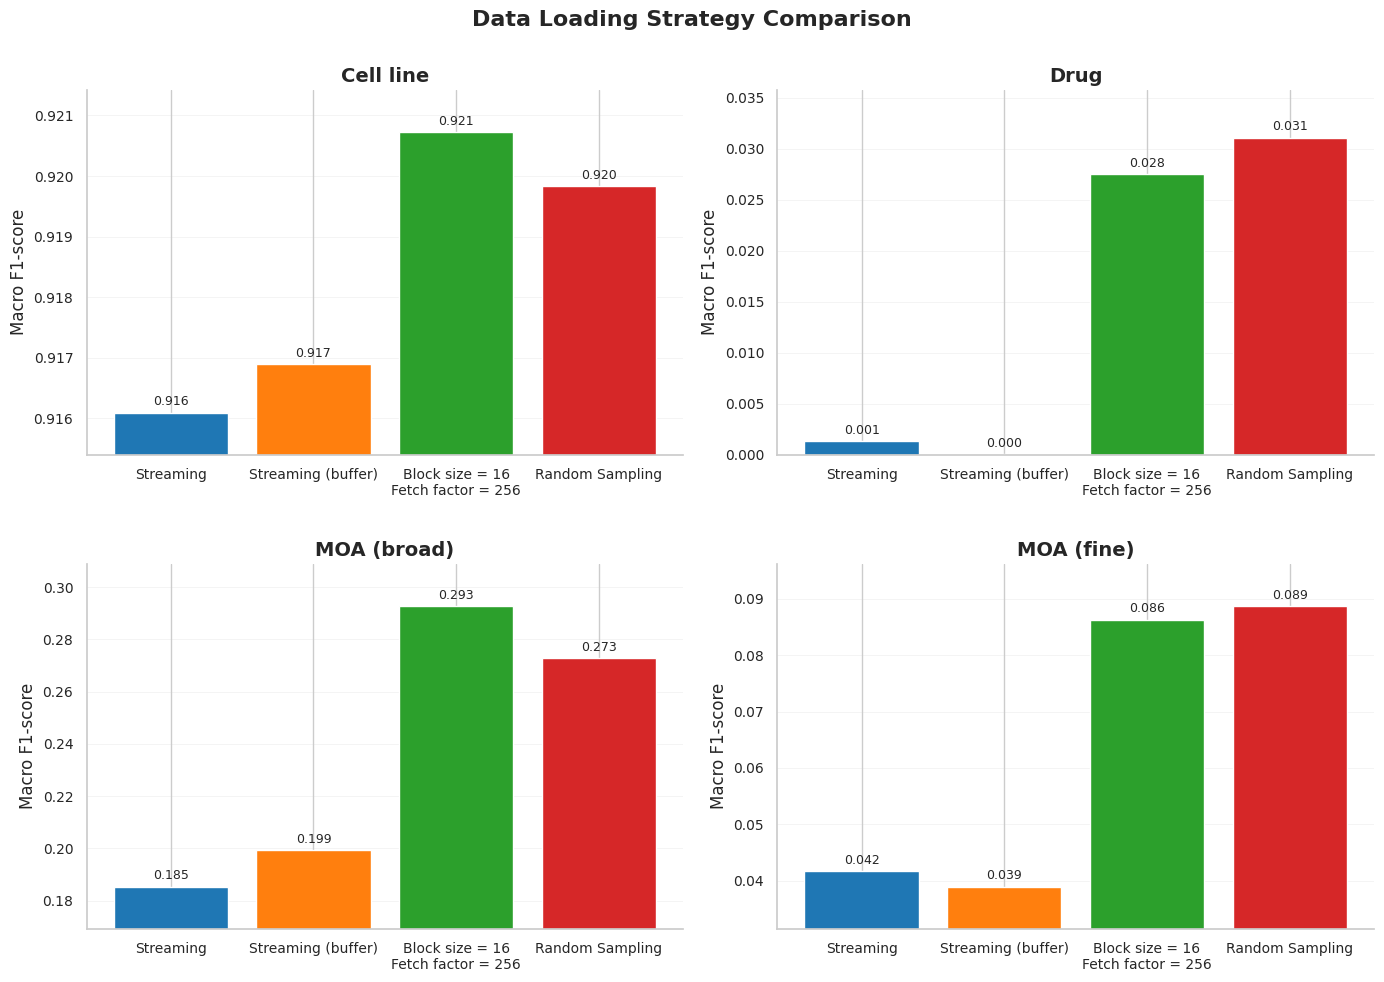

In [18]:
# Define custom y-axis limits for each task
# Adjust these based on your results
ylim_dict = {
    'Cell line': (0.8, 0.95),
    'Drug': (0.0, 0.035),
    'MOA (broad)': (0.0, 0.35),
    'MOA (fine)': (0.0, 0.09),
}

# Generate the comparison plot
if 'df' in dir() and len(df) > 0:
    fig, axes = plot_comparison(
        df,
        #ylim_dict=ylim_dict,
        figsize=(14, 10),
        title="Data Loading Strategy Comparison"
    )
    
    # Save figure (both PNG and PDF)
    output_path_png = RESULTS_DIR / "comparison_plot.png"
    output_path_pdf = RESULTS_DIR / "comparison_plot.pdf"
    fig.savefig(output_path_png, dpi=150, bbox_inches='tight')
    fig.savefig(output_path_pdf, bbox_inches='tight')
    print(f"\nFigure saved to: {output_path_png}")
    print(f"Figure saved to: {output_path_pdf}")
    
    plt.show()
else:
    print("No data available for plotting")

## Training Time Comparison

Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/time_comparison.png
Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/time_comparison.pdf


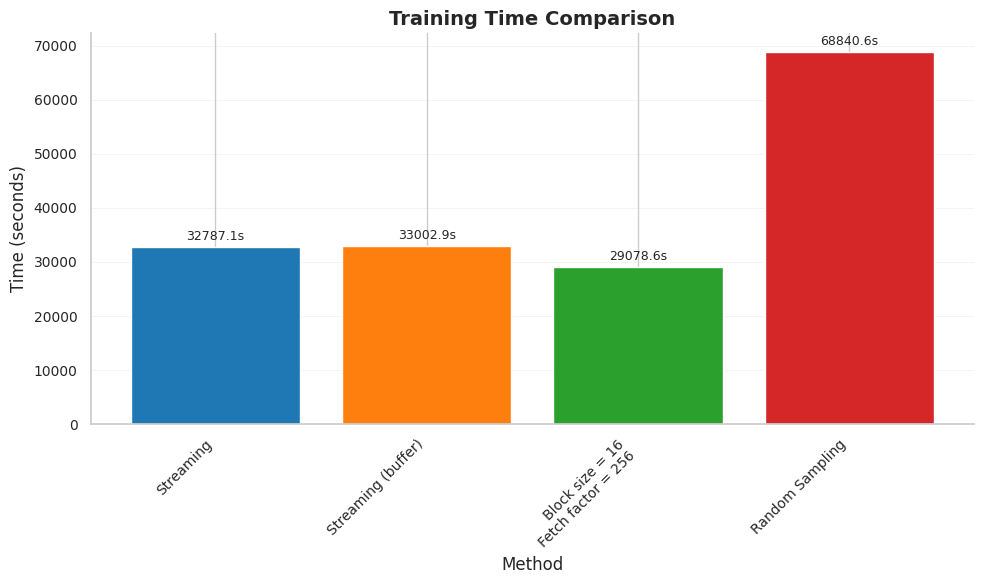

In [19]:
# Plot training time comparison
if results:
    time_df = get_time_comparison(results)
    
    if len(time_df) > 0:
        fig, ax = plot_time_comparison(time_df)
        
        # Save figure (both PNG and PDF)
        output_path_png = RESULTS_DIR / "time_comparison.png"
        output_path_pdf = RESULTS_DIR / "time_comparison.pdf"
        fig.savefig(output_path_png, dpi=150, bbox_inches='tight')
        fig.savefig(output_path_pdf, bbox_inches='tight')
        print(f"Figure saved to: {output_path_png}")
        print(f"Figure saved to: {output_path_pdf}")
        
        plt.show()
    else:
        print("No timing data available")
else:
    print("No results loaded")

## Training Curves

/tmp/ipykernel_654464/1392450033.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=8)


Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/training_curves.png
Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/training_curves.pdf


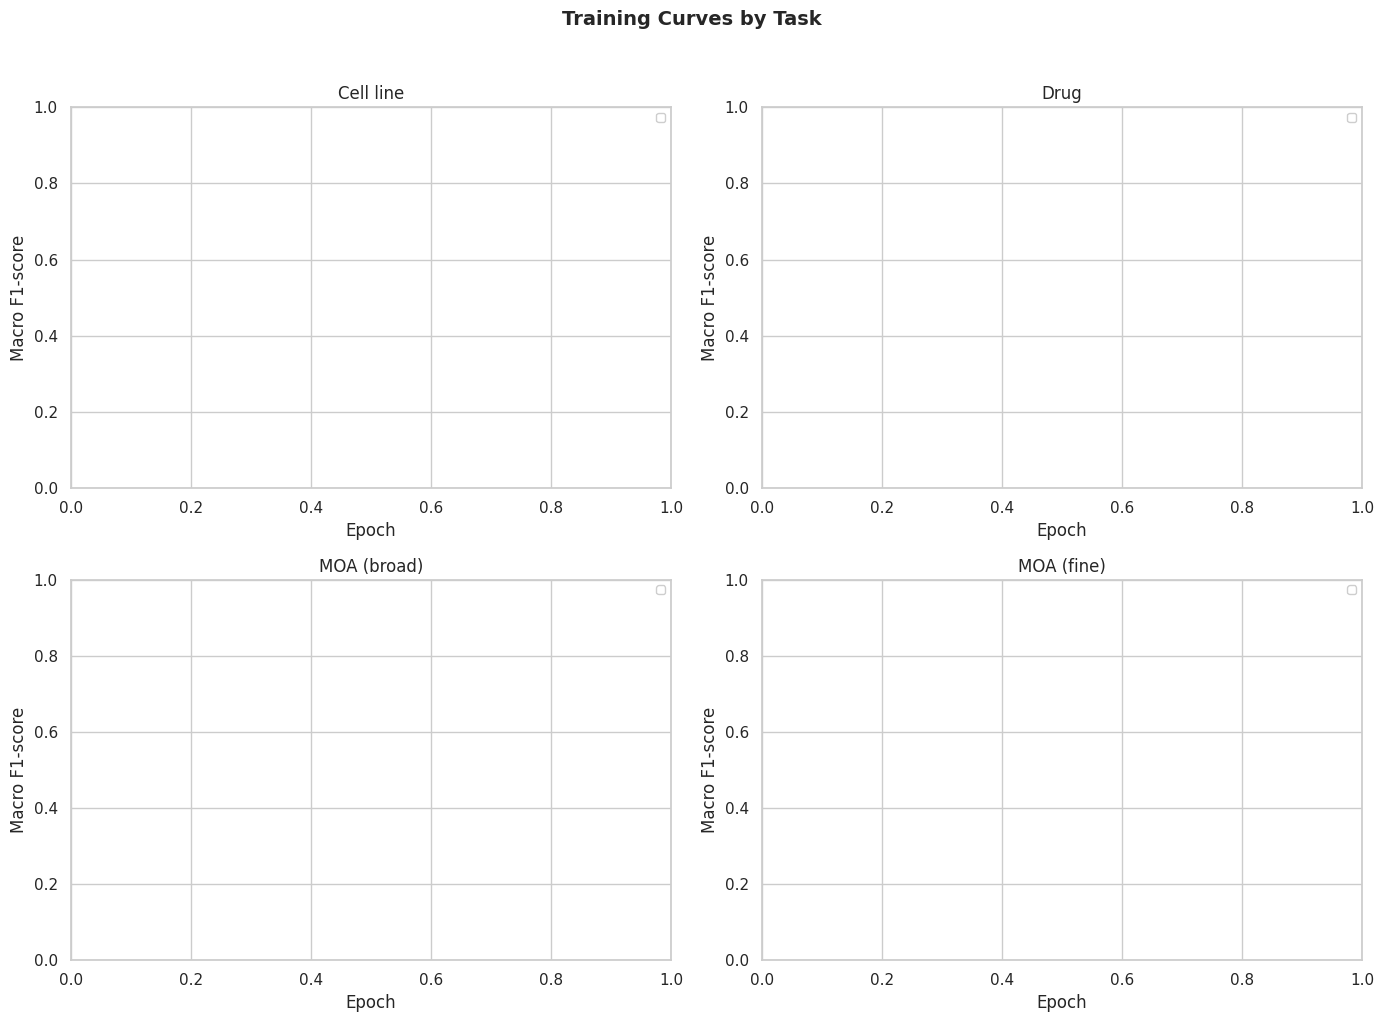

In [20]:
# Plot training curves for each task
if results:
    tasks = ['cell_line', 'drug', 'moa_broad', 'moa_fine']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, task in enumerate(tasks):
        ax = axes[idx]
        
        for strategy, result in results.items():
            if result.get('status') != 'success':
                continue
            
            history = result.get('history', {})
            metric_key = f'val_{task}_f1_macro'
            
            if metric_key in history:
                values = history[metric_key]
                epochs = list(range(1, len(values) + 1))
                label = STRATEGY_DISPLAY_NAMES.get(strategy, strategy).replace('\n', ' ')
                ax.plot(epochs, values, label=label, marker='o', markersize=4)
        
        task_name = TASK_DISPLAY_NAMES.get(task, task)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Macro F1-score')
        ax.set_title(task_name)
        ax.legend(loc='best', fontsize=8)
    
    plt.suptitle('Training Curves by Task', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure (both PNG and PDF)
    output_path_png = RESULTS_DIR / "training_curves.png"
    output_path_pdf = RESULTS_DIR / "training_curves.pdf"
    fig.savefig(output_path_png, dpi=150, bbox_inches='tight')
    fig.savefig(output_path_pdf, bbox_inches='tight')
    print(f"Figure saved to: {output_path_png}")
    print(f"Figure saved to: {output_path_pdf}")
    
    plt.show()
else:
    print("No results loaded")

## Export Results to CSV

In [21]:
# Export comparison data to CSV
if 'df' in dir() and len(df) > 0:
    csv_path = RESULTS_DIR / "comparison_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"Results exported to: {csv_path}")
    
    # Also create a pivot table
    pivot_df = df.pivot(index='Method', columns='Task', values='Macro F1-score')
    pivot_path = RESULTS_DIR / "comparison_pivot.csv"
    pivot_df.to_csv(pivot_path)
    print(f"Pivot table exported to: {pivot_path}")
    
    print("\nPivot Table:")
    display(pivot_df)

Results exported to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_results.csv
Pivot table exported to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_pivot.csv

Pivot Table:


Task,Cell line,Drug,MOA (broad),MOA (fine)
Method,,,,
Block size = 16\nFetch factor = 256,0.920726,0.027502,0.292772,0.086327
Random Sampling,0.919829,0.031084,0.272784,0.088730
Streaming,0.916096,0.001307,0.185371,0.041731
Streaming (buffer),0.916899,0.000028,0.199403,0.038951


## Summary Statistics

In [22]:
# Print summary statistics
if 'df' in dir() and len(df) > 0:
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    # Best method per task
    print("\nBest method per task:")
    for task in df['Task'].unique():
        task_data = df[df['Task'] == task]
        best_idx = task_data['Macro F1-score'].idxmax()
        best_row = df.loc[best_idx]
        print(f"  {task}: {best_row['Method'].replace(chr(10), ' ')} (F1 = {best_row['Macro F1-score']:.4f})")
    
    # Overall method comparison
    print("\nMean performance across all tasks:")
    mean_by_method = df.groupby('Method')['Macro F1-score'].mean().sort_values(ascending=False)
    for method, score in mean_by_method.items():
        print(f"  {method.replace(chr(10), ' ')}: {score:.4f}")
    
    print("\n" + "="*60)


SUMMARY STATISTICS

Best method per task:
  Cell line: Block size = 16 Fetch factor = 256 (F1 = 0.9207)
  Drug: Random Sampling (F1 = 0.0311)
  MOA (broad): Block size = 16 Fetch factor = 256 (F1 = 0.2928)
  MOA (fine): Random Sampling (F1 = 0.0887)

Mean performance across all tasks:
  Block size = 16 Fetch factor = 256: 0.3318
  Random Sampling: 0.3281
  Streaming (buffer): 0.2888
  Streaming: 0.2861

